In [123]:
import numpy as np
import pandas as pd
import os
import sys

import tarfile
from driver import load_challenge_data, get_classes

import matplotlib.pyplot as plt
import seaborn as sns

from get_12ECG_features import get_12ECG_features

import warnings
warnings.filterwarnings('ignore')

In [67]:
!wget -O PhysioNetChallenge2020_Training_CPSC.tar.gz \
https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_CPSC.tar.gz/

--2020-06-16 07:57:05--  https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_CPSC.tar.gz/
Resolving cloudypipeline.com (cloudypipeline.com)... 34.74.104.185
Connecting to cloudypipeline.com (cloudypipeline.com)|34.74.104.185|:9555... connected.
HTTP request sent, awaiting response... 200 
Length: 859952525 (820M) [application/octet-stream]
Saving to: ‘PhysioNetChallenge2020_Training_CPSC.tar.gz’

PhysioNetChallenge2 100%[===================>] 820.11M  33.2MB/s    in 27s     

2020-06-16 07:57:33 (30.4 MB/s) - ‘PhysioNetChallenge2020_Training_CPSC.tar.gz’ saved [859952525/859952525]



In [68]:
my_tar = tarfile.open('PhysioNetChallenge2020_Training_CPSC.tar.gz')
my_tar.extractall('./data') # specify which folder to extract to
my_tar.close()

In [124]:
input_files = []
input_directory = 'data/Training_WFDB/'
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
           input_files.append(f)

In [125]:
#Create a dictionary with classes, for visual purposes and undertand better the diagnosis
classes = get_classes(input_directory, input_files );
classes_dict = dict(zip(classes, ['PVC', 'AF', 'LBBB', 'STE' , 'IAVB', 'PAC', 'Normal', 'STD', 'RBBB' ]))
classes_dict

{'164884008': 'PVC',
 '164889003': 'AF',
 '164909002': 'LBBB',
 '164931005': 'STE',
 '270492004': 'IAVB',
 '284470004': 'PAC',
 '426783006': 'Normal',
 '429622005': 'STD',
 '59118001': 'RBBB'}

In [126]:
def get_diagnosis(input_file):
    for lines in input_file:
        if lines.startswith('#Dx'):
            tmp = lines.split(': ')[1].split(',')
            for c in tmp:
                tmp = c.strip()        
    return tmp

In [127]:
# Load all data in a data frame with the diagnosis as the target column.
# I use the provided function get_12ECG_features, which only takes into accout lead 1 of the ECG  
# and only makes calculations regarding the RR parameter, in amplitude and time. To evaluate RR characteristics,
# taking into account only lead one, might be sufficient. 
# However, feature extraction could be improved by detecting other ECG relevant parameters, such as PR time, 
# ST time or width of the QRS complex. Taking into account these paramenters would improve the machine learning 
# model and predictions. Note that RR information is not meaningful for some of the targeted arrythmias.

df = pd.DataFrame(columns = ['age','sex','mean_RR','mean_Peaks','median_RR','median_Peaks',
                             'std_RR','std_Peaks','var_RR','var_Peaks','skew_RR','skew_Peaks',
                             'kurt_RR','kurt_Peaks', 'target'])
for i,f in enumerate(input_files):
    tmp_input_file = os.path.join(input_directory, f)
    data, header_data = load_challenge_data(tmp_input_file)
    #These features are only the ones related to lead 1
    features=list(get_12ECG_features(data, header_data))
    target = (get_diagnosis(header_data))
    features.append(classes_dict[target])
    df.loc[i] = (features)

In [128]:
df.head()

,age,sex,mean_RR,mean_Peaks,median_RR,median_Peaks,std_RR,std_Peaks,var_RR,var_Peaks,skew_RR,skew_Peaks,kurt_RR,kurt_Peaks,target
0,76.0,1.0,8541.333333,2.149689e+05,9122.0,2.482889e+05,4811.722244,2.256133e+05,2.387619e+07,5.249201e+10,-0.201395,2.630562,-1.265014,9.783462,STD
1,32.0,1.0,4934.615385,1.046937e+06,4837.0,8.038087e+04,2969.611877,1.084130e+06,9.171338e+06,1.222352e+12,0.074065,0.286475,-1.226745,-1.759897,Normal
2,65.0,1.0,5552.555556,1.057167e+06,5553.0,1.088333e+06,3251.524962,1.034741e+05,1.119432e+07,1.133670e+10,0.002754,-0.530312,-1.207725,-1.088446,LBBB
3,44.0,0.0,10857.466667,1.475160e+06,11220.0,1.646322e+06,6663.278591,5.846316e+05,4.593029e+07,3.535801e+11,0.051425,-1.978140,-1.146487,2.253281,STE
4,75.0,0.0,5724.947368,1.378173e+06,5890.0,1.948875e+06,3352.654023,9.311654e+05,1.186475e+07,9.152396e+11,-0.060184,-0.776518,-1.155981,-1.373767,IAVB


In [129]:
#Factorize categorical target for modeling
df['target'], label = pd.factorize(df['target'])

In [130]:
df.head()

,age,sex,mean_RR,mean_Peaks,median_RR,median_Peaks,std_RR,std_Peaks,var_RR,var_Peaks,skew_RR,skew_Peaks,kurt_RR,kurt_Peaks,target
0,76.0,1.0,8541.333333,2.149689e+05,9122.0,2.482889e+05,4811.722244,2.256133e+05,2.387619e+07,5.249201e+10,-0.201395,2.630562,-1.265014,9.783462,0
1,32.0,1.0,4934.615385,1.046937e+06,4837.0,8.038087e+04,2969.611877,1.084130e+06,9.171338e+06,1.222352e+12,0.074065,0.286475,-1.226745,-1.759897,1
2,65.0,1.0,5552.555556,1.057167e+06,5553.0,1.088333e+06,3251.524962,1.034741e+05,1.119432e+07,1.133670e+10,0.002754,-0.530312,-1.207725,-1.088446,2
3,44.0,0.0,10857.466667,1.475160e+06,11220.0,1.646322e+06,6663.278591,5.846316e+05,4.593029e+07,3.535801e+11,0.051425,-1.978140,-1.146487,2.253281,3
4,75.0,0.0,5724.947368,1.378173e+06,5890.0,1.948875e+06,3352.654023,9.311654e+05,1.186475e+07,9.152396e+11,-0.060184,-0.776518,-1.155981,-1.373767,4


In [131]:
label

Index(['STD', 'Normal', 'LBBB', 'STE', 'IAVB', 'RBBB', 'AF', 'PAC', 'PVC'], dtype='object')

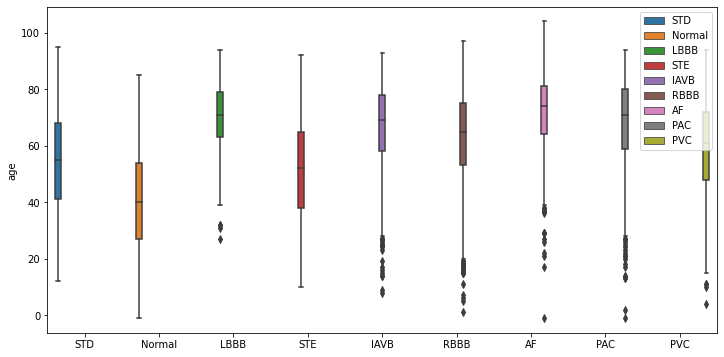

In [159]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=label[df['target']], y=df['age'], hue=label[df['target']]);
plt.legend(loc='upper right');

We see that some arrythmias such as 1st degree AV block (IAVB), right bundle brach block (RBBB), premature atrial contraction (PAC) or atrial fibrilation (AF) are more common at ages higher than 60. However, they also have a lot of outliers, having very young patients suffering from these cardiac pathologies.

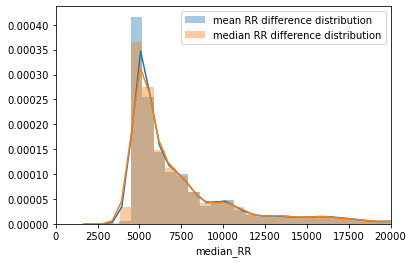

In [132]:
# Let us better understand the data by plotting some distributions 
sns.distplot(df['mean_RR'],bins=100, label='mean RR difference distribution');
sns.distplot(df['median_RR'],bins=100, label='median RR difference distribution');
# I set a higher cutoff at around 3 times the standard deviation with respect to the mean
plt.xlim([0,20000])
plt.legend();

There is almost a normal distribution, mean and median are very close. However, we have some high outliers, meaning there is a light right skewed distribution.

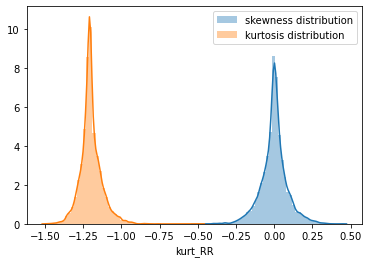

In [78]:
sns.distplot(df['skew_RR'], label='skewness distribution');
sns.distplot(df['kurt_RR'], label='kurtosis distribution');
plt.legend();

From these plots we confirm what we saw in the previous "RR time difference" distributions. There is a slightly skewed right distribution. In addition, there is a negative kurtosis, lower than -1, meaning there is less concentration of values around the mean and the distribution is quite flat.

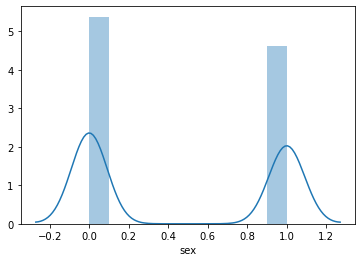

In [79]:
# confirmation that sex distribution is quite balanced in all observations
sns.distplot(df['sex'], norm_hist=True)

## Let us start modeling the classification problem


In [80]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [81]:
# Create target object and call it y
y = df['target']
# Create X
X = df.loc[:, df.columns != 'target']

#Scale the feature data before spliting
scaler = StandardScaler()
X_scaled = pd.DataFrame(data= scaler.fit_transform(X), columns=X.columns)

# Split into validation and training data
train_X, test_X, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

#Create a data frame which will store all the model scores
model_score = pd.DataFrame(index = ['Model Score','Model'])

# Decision tree classifier

In [82]:
from sklearn.tree import DecisionTreeClassifier

# Specify Model
tree_model = DecisionTreeClassifier(random_state=1)
# Fit Model
tree_model.fit(train_X, train_y)

# Make validation predictions and calculate accuracy
predictions = tree_model.predict(test_X)
val_acc = accuracy_score(predictions, test_y)
print("Validation accuracy: {:,.3f}".format(val_acc))

Validation accuracy: 0.312


In [83]:
#Let us use Randomized Grid search to optimize several hyperparameters

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_leaf_nodes" : np.arange(10,200,10),
              "max_depth": np.arange(1, 10),
              "max_features": np.arange(1, 9),
              "min_samples_leaf": np.arange(1, 9),
              "criterion": ["gini", "entropy"]}

tree_cv = RandomizedSearchCV(tree_model, param_dist, cv=5, random_state=1)

# Fit it to the data
tree_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'min_samples_leaf': 8, 'max_leaf_nodes': 160, 'max_features': 7, 'max_depth': 7, 'criterion': 'entropy'}
Best score is 0.34466171249277516


In [84]:
#Create tree model with the best hyperparameters
best_tree_model = tree_cv.best_estimator_.fit(train_X,train_y)

In [85]:
predictions = best_tree_model.predict(test_X)
val_acc = accuracy_score(val_predictions, test_y)
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       0.38      0.31      0.34       176
           1       0.50      0.58      0.54       181
           2       0.50      0.04      0.08        48
           3       0.07      0.03      0.04        33
           4       0.28      0.13      0.17       142
           5       0.32      0.57      0.41       338
           6       0.32      0.40      0.35       201
           7       0.38      0.07      0.12       131
           8       0.28      0.15      0.20       126

    accuracy                           0.35      1376
   macro avg       0.34      0.25      0.25      1376
weighted avg       0.35      0.35      0.32      1376



In [86]:
score = cross_val_score(best_tree_model, X, y, cv=5).mean()
score

0.33212145877378435

In [87]:
model_score['DecisionTree'] =  [score, best_tree_model]

# Random Forest Classifier

In [88]:
from sklearn.ensemble import RandomForestClassifier

# Define the model. Set random_state to 1
rf_model = RandomForestClassifier(random_state=1)

# fit the model
rf_model.fit(train_X,train_y)

# Calculate the accuracy of your Random Forest model on the validation data
predict_y=rf_model.predict(test_X)
rf_val = accuracy_score(test_y,predict_y)

print("Prediction accuracy for Random Forest Model: {}".format(rf_val))

Prediction accuracy for Random Forest Model: 0.42369186046511625


In [89]:
#Let us use Randomized Grid search to optimize several hyperparameters

# Setup the parameters and distributions 
param_dist = {"max_leaf_nodes" : np.arange(2,300,30),
              "max_depth": np.arange(3, 40,10),
              "max_features": np.arange(1, 9),
              "min_samples_leaf": np.arange(1, 9),
              "criterion": ["gini", "entropy"]}

# Create the RandomizedSearchCV object
forest_cv = RandomizedSearchCV(rf_model, param_dist, cv=5, random_state=1)

# Fit it to the data
forest_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Forest Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_))

Tuned Forest Parameters: {'min_samples_leaf': 2, 'max_leaf_nodes': 242, 'max_features': 5, 'max_depth': 23, 'criterion': 'entropy'}
Best score is 0.393382544793989


In [90]:
#Create forest model with the best hyperparameters
best_forest_model = forest_cv.best_estimator_.fit(train_X,train_y)

In [91]:
predictions = best_forest_model.predict(test_X)
val_acc = accuracy_score(predictions, test_y)
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       0.39      0.35      0.37       176
           1       0.47      0.64      0.54       181
           2       1.00      0.02      0.04        48
           3       0.43      0.09      0.15        33
           4       0.29      0.18      0.22       142
           5       0.38      0.63      0.47       338
           6       0.39      0.44      0.41       201
           7       0.33      0.05      0.08       131
           8       0.39      0.21      0.28       126

    accuracy                           0.39      1376
   macro avg       0.45      0.29      0.29      1376
weighted avg       0.40      0.39      0.36      1376



In [92]:
score = cross_val_score(best_forest_model, X, y, cv=5).mean()
score

0.39217579281183934

In [93]:
model_score['RandomForest'] =  [score, best_forest_model]

# K-Neighbors model

In [94]:
# Instantiate and fit a k-NN classifier to the unscaled data

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_X, train_y)


KNeighborsClassifier(n_neighbors=3)

In [95]:
predict_y=knn.predict(test_X)
rf_val = accuracy_score(test_y,predict_y)

print("Prediction accuracy for Knn model: {}".format(rf_val))

Prediction accuracy for Knn model: 0.26453488372093026


In [96]:
#Let us use Randomized Grid search to optimize number of neighbors hyperparameters

# Setup the parameters and distributions 
param_dist = {"n_neighbors" : np.arange(1,10)}

# Create the RandomizedSearchCV object, scoring the recall
knn_cv = RandomizedSearchCV(knn, param_dist, cv=5, random_state=1)

# Fit it to the data
knn_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Forest Parameters: {}".format(knn_cv.best_params_))
print("Best score is {}".format(knn_cv.best_score_))

Tuned Forest Parameters: {'n_neighbors': 9}
Best score is 0.2930357526215837


In [97]:
#Create knn model with the best hyperparameters
best_knn_model = knn_cv.best_estimator_.fit(train_X,train_y)

In [98]:
predictions = best_knn_model.predict(test_X)
val_acc = accuracy_score(predictions, test_y)
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       0.31      0.39      0.35       176
           1       0.37      0.55      0.44       181
           2       0.08      0.04      0.05        48
           3       0.14      0.12      0.13        33
           4       0.14      0.10      0.12       142
           5       0.33      0.45      0.38       338
           6       0.29      0.24      0.26       201
           7       0.30      0.10      0.15       131
           8       0.26      0.14      0.19       126

    accuracy                           0.31      1376
   macro avg       0.25      0.24      0.23      1376
weighted avg       0.29      0.31      0.28      1376



In [99]:
score = cross_val_score(best_knn_model, X, y, cv=5).mean()
score

0.19296099365750527

In [100]:
model_score['K-neighbors'] =  [score, best_knn_model]

# XGBoost

In [101]:
import xgboost as xgb
from xgboost import XGBClassifier

xgbModel = XGBClassifier()
xgbModel.fit(train_X,train_y)

XGBClassifier(objective='multi:softprob')

In [102]:
#Do a simple precition before tuning the model to see the accuracy
predictions = xgbModel.predict(test_X)
val_acc = accuracy_score(predictions, test_y)
print("Test accuracy: {:,.3f}".format(val_acc))

Validation accuracy: 0.384


In [103]:
#We have explored the data and got the test prediction error. Let us now tune the model to improve the performance
#tuning the hyperparameters

gbm_param_grid = {
    'n_estimators': np.arange(10,1000,200),
    'max_depth': range(2, 12),
    'learning_rate': np.arange(0.1,0.5,0.1)
}

# Perform random search of hyperparameteres
r_xgb = RandomizedSearchCV(estimator=xgbModel, param_distributions=gbm_param_grid, cv=3, 
                                    n_iter=5, verbose=1, random_state=42, n_jobs=-1)

# Fit best_xgb to the data
r_xgb.fit(X,y)

# Print the best parameters
print("Best parameters found: ", r_xgb.best_params_)
print("Highest score: ", (r_xgb.best_score_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.7min finished


Best parameters found:  {'n_estimators': 610, 'max_depth': 3, 'learning_rate': 0.4}
Highest score:  0.38476068627816606


In [104]:
best_xgb = r_xgb.best_estimator_.fit(train_X,train_y)

In [105]:
predictions = best_xgb.predict(test_X)
val_acc = accuracy_score(predictions, test_y)
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       0.38      0.34      0.35       176
           1       0.47      0.57      0.52       181
           2       0.62      0.17      0.26        48
           3       0.50      0.27      0.35        33
           4       0.17      0.13      0.15       142
           5       0.42      0.56      0.48       338
           6       0.40      0.42      0.41       201
           7       0.29      0.18      0.22       131
           8       0.39      0.36      0.37       126

    accuracy                           0.39      1376
   macro avg       0.40      0.33      0.35      1376
weighted avg       0.39      0.39      0.38      1376



In [106]:
score = cross_val_score(best_xgb, X, y, cv=5).mean()
score

0.38941162790697675

In [107]:
model_score['XGBBoost'] =  [val_acc, best_xgb]

In [109]:
final_scores = pd.DataFrame(model_score).transpose()
final_scores.sort_values(by='Model Score' ,ascending=False, inplace=True)
final_scores

,Model Score,Model
XGBBoost,0.392442,"XGBClassifier(learning_rate=0.4, n_estimators=..."
RandomForest,0.392176,"(DecisionTreeClassifier(criterion='entropy', m..."
DecisionTree,0.332121,"DecisionTreeClassifier(criterion='entropy', ma..."
K-neighbors,0.192961,KNeighborsClassifier(n_neighbors=9)


As we can see, the trained model performance is not very accurate. This is due to a poor feature extraction of the data. As I mentioned before, taking into account only RR characteristics in the ECG to detect arrythmias is not enough.
In the dataframe we should include information about P, QRS, T waves, time between waves, amplitude, etc. For that purpose, ECG segmentation functions need to be developed.

Just as an example, arrythmias such as atrial fibrilation are strongly related to the P wave of the ECG, and we have not included this information in the model. Therefore, the model does not detect this arrythmia accurately.

In [120]:
# Since XGBoost and RandomForest classifiers have a similar performance, I have decided to take 
# the Randomforest, because it trains and runs faster.
best_model = final_scores['Model']['RandomForest']

In [121]:
# Save the best model for further predictions
import pickle
pickle.dump(best_model,open("classifier.model","wb"))

In [122]:
# Execute the driver using the saved classifier.model.
# The first argument is the data input folder and the second argument is the folder where we save the predictions.
!python driver.py ./data/Training_WFDB/ output

Loading 12ECG model...
Extracting 12ECG features...
    1/6877...
    2/6877...
    3/6877...
    4/6877...
    5/6877...
    6/6877...
    7/6877...
    8/6877...
    9/6877...
    10/6877...
    11/6877...
    12/6877...
    13/6877...
    14/6877...
    15/6877...
    16/6877...
    17/6877...
    18/6877...
    19/6877...
    20/6877...
    21/6877...
    22/6877...
    23/6877...
    24/6877...
    25/6877...
    26/6877...
    27/6877...
    28/6877...
    29/6877...
    30/6877...
    31/6877...
    32/6877...
    33/6877...
    34/6877...
    35/6877...
    36/6877...
    37/6877...
    38/6877...
    39/6877...
    40/6877...
    41/6877...
    42/6877...
    43/6877...
    44/6877...
    45/6877...
    46/6877...
    47/6877...
    48/6877...
    49/6877...
    50/6877...
    51/6877...
    52/6877...
    53/6877...
    54/6877...
    55/6877...
    56/6877...
    57/6877...
    58/6877...
    59/6877...
    60/6877...
    61/6877...
    62/6877...
    63/6877...
    64/6877.